<a href="https://colab.research.google.com/github/ayarii/learner-engagement/blob/main/learner_'s_engagement_2method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Import data from Google Drive**

In [1]:
import cv2
import numpy as np
import requests
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
import datetime
from tensorflow import keras
from tensorflow.keras.models import Model
import tensorflow as tf
import pathlib
import os
import zipfile
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_curve, auc
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras import layers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator



In [2]:
#Import dataset
data_dir = tf.keras.utils.get_file(
    "dataset.zip",
    "https://github.com/ayarii/learner-engagement/blob/main/Student-engagement-dataset.zip?raw=true",
    extract=False)
with zipfile.ZipFile(data_dir, 'r') as zip_ref:
    zip_ref.extractall('/content/datasets')
data_dir = pathlib.Path('/content/datasets/Student-engagement-dataset')
print(data_dir)
print(os.path.abspath(data_dir))

40069772/40069772 [==============================] - 0s 0us/step
/content/datasets/Student-engagement-dataset
/content/datasets/Student-engagement-dataset


In [3]:
image_count = len(list(data_dir.glob('*/*')))
print(image_count)

2120


Populating the interactive namespace from numpy and matplotlib
Shape of the image (72307,)


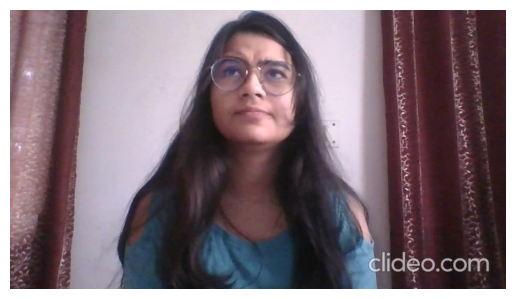

Shape of the image (19745,)


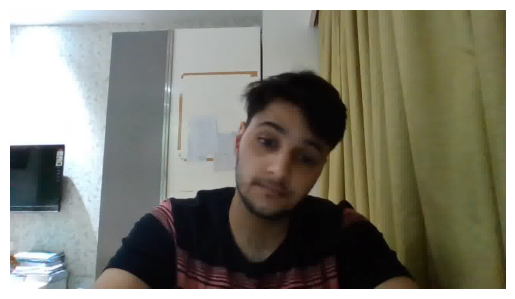

Shape of the image (21216,)


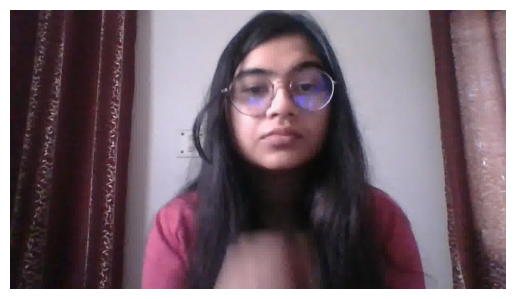

Shape of the image (21813,)


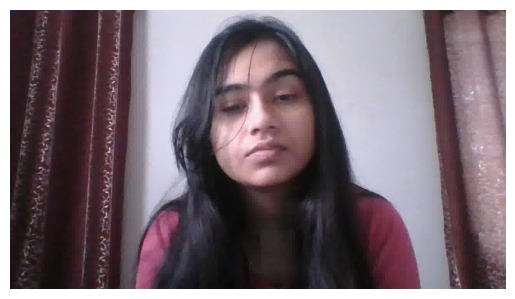

Shape of the image (17353,)


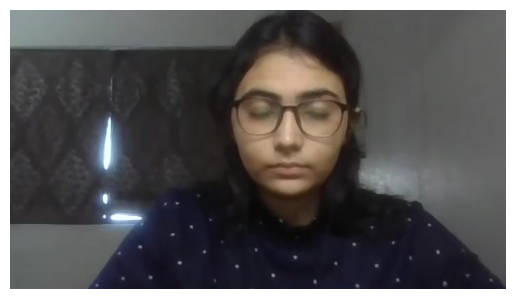

Shape of the image (44759,)


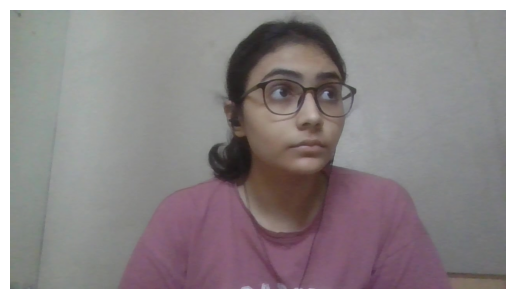

In [4]:
%pylab inline
#learner confused
url_confused = r'https://github.com/ayarii/learner-engagement/blob/main/0020.jpg?raw=true'
resp = requests.get(url_confused, stream=True).raw
image_array_confused = np.asarray(bytearray(resp.read()), dtype="uint8")
print(f'Shape of the image {image_array_confused.shape}')
image_confused = cv2.imdecode(image_array_confused, cv2.IMREAD_COLOR)
plt.axis('off')
plt.imshow(cv2.cvtColor(image_confused, cv2.COLOR_BGR2RGB))
plt.show()

#learner frustrated
url_frustrated = r'https://github.com/ayarii/learner-engagement/blob/main/135.jpg?raw=true'
resp = requests.get(url_frustrated, stream=True).raw
image_array_frustrated= np.asarray(bytearray(resp.read()), dtype="uint8")
print(f'Shape of the image {image_array_frustrated.shape}')
image_frustrated = cv2.imdecode(image_array_frustrated, cv2.IMREAD_COLOR)
plt.axis('off')
plt.imshow(cv2.cvtColor(image_frustrated, cv2.COLOR_BGR2RGB))
plt.show()

#learner engaged
url_engaged = r'https://github.com/ayarii/learner-engagement/blob/main/0076.jpg?raw=true'
resp = requests.get(url_engaged, stream=True).raw
image_array_engagement = np.asarray(bytearray(resp.read()), dtype="uint8")
print(f'Shape of the image {image_array_engagement.shape}')
image_engagement = cv2.imdecode(image_array_engagement, cv2.IMREAD_COLOR)
plt.axis('off')
plt.imshow(cv2.cvtColor(image_engagement, cv2.COLOR_BGR2RGB))
plt.show()

#learner bored
url_bored = r'https://github.com/ayarii/learner-engagement/blob/main/0153.jpg?raw=true'
resp = requests.get(url_bored, stream=True).raw
image_array_bored = np.asarray(bytearray(resp.read()), dtype="uint8")
print(f'Shape of the image {image_array_bored.shape}')
image_bored = cv2.imdecode(image_array_bored, cv2.IMREAD_COLOR)
plt.axis('off')
plt.imshow(cv2.cvtColor(image_bored, cv2.COLOR_BGR2RGB))
plt.show()

#learner drowsy
url_drowsy = r'https://github.com/ayarii/learner-engagement/blob/main/0021.jpg?raw=true'
resp = requests.get(url_drowsy, stream=True).raw
image_array_drowsy = np.asarray(bytearray(resp.read()), dtype="uint8")
print(f'Shape of the image {image_array_drowsy.shape}')
image_drowsy = cv2.imdecode(image_array_drowsy, cv2.IMREAD_COLOR)
plt.axis('off')
plt.imshow(cv2.cvtColor(image_drowsy, cv2.COLOR_BGR2RGB))
plt.show()

# learner looking_away
url_looking_away = r'https://github.com/ayarii/learner-engagement/blob/main/0011.jpg?raw=true'
resp = requests.get(url_looking_away, stream=True).raw
image_array_looking_away = np.asarray(bytearray(resp.read()), dtype="uint8")
print(f'Shape of the image {image_array_looking_away.shape}')
image_looking_away = cv2.imdecode(image_array_looking_away, cv2.IMREAD_COLOR)
plt.axis('off')
plt.imshow(cv2.cvtColor(image_looking_away, cv2.COLOR_BGR2RGB))
plt.show()

In [5]:
# Image dimensions and batch size
img_height = 200
img_width = 200
batch_size = 32

# Create the training dataset
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)


# Create the validation dataset
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

# Get the file paths
file_paths = train_data.file_paths

# Print the first 10 file paths
for path in file_paths[:10]:
    print(path)

Found 2120 files belonging to 6 classes.
Using 1696 files for training.
Found 2120 files belonging to 6 classes.
Using 424 files for validation.
/content/datasets/Student-engagement-dataset/confused/0061.jpg
/content/datasets/Student-engagement-dataset/drowsy/0463.jpg
/content/datasets/Student-engagement-dataset/Looking Away/0354.jpg
/content/datasets/Student-engagement-dataset/engaged/0314.jpg
/content/datasets/Student-engagement-dataset/frustrated/0197.jpg
/content/datasets/Student-engagement-dataset/frustrated/0216.jpg
/content/datasets/Student-engagement-dataset/drowsy/0033.jpg
/content/datasets/Student-engagement-dataset/engaged/0397.jpg
/content/datasets/Student-engagement-dataset/bored/0148.jpg
/content/datasets/Student-engagement-dataset/drowsy/0245.jpg


In [6]:
num_classes = 6
img_size = (200, 200,3)
model = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(200, 200, 3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])
# Compile the model
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Set up callbacks
log_dir = "logs/"
tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_images=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=100,
    callbacks=[tensorboard_callback, early_stopping]
)
# Evaluate the model
loss, accuracy = model.evaluate(val_data, verbose=0)
print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')



Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


53/53 [==============================] - 12s 118ms/step - loss: 0.4806 - accuracy: 0.8302 - val_loss: 0.2095 - val_accuracy: 0.8726
Epoch 2/100
53/53 [==============================] - 7s 110ms/step - loss: 0.1314 - accuracy: 0.9410 - val_loss: 0.1229 - val_accuracy: 0.9410
Epoch 3/100
53/53 [==============================] - 8s 139ms/step - loss: 0.0825 - accuracy: 0.9575 - val_loss: 0.1147 - val_accuracy: 0.9316
Epoch 4/100
53/53 [==============================] - 6s 103ms/step - loss: 0.0781 - accuracy: 0.9617 - val_loss: 0.0990 - val_accuracy: 0.9552
Epoch 5/100
53/53 [==============================] - 7s 126ms/step - loss: 0.0741 - accuracy: 0.9682 - val_loss: 0.1493 - val_accuracy: 0.9222
Epoch 6/100
53/53 [==============================] - 6s 107ms/step - loss: 0.0766 - accuracy: 0.9652 - val_loss: 0.0995 - val_accuracy: 0.9552
Epoch 7/100
53/53 [==============================] - 7s 128ms/step - loss: 0.0710 - accuracy: 0.9634 - val_loss: 0.0872 - val_accuracy: 0.9458
Epoch 8/10

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 99, 99, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 48, 48, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 32)        9

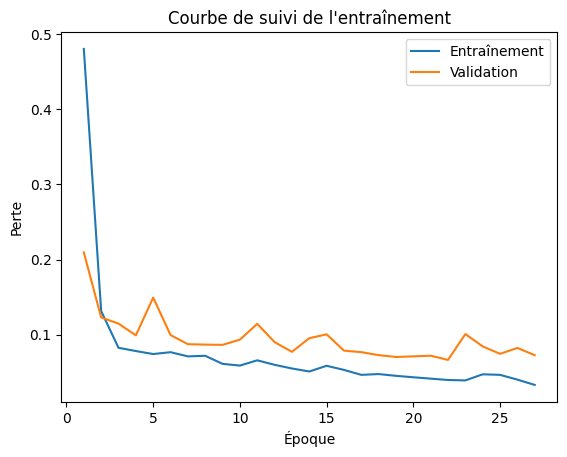

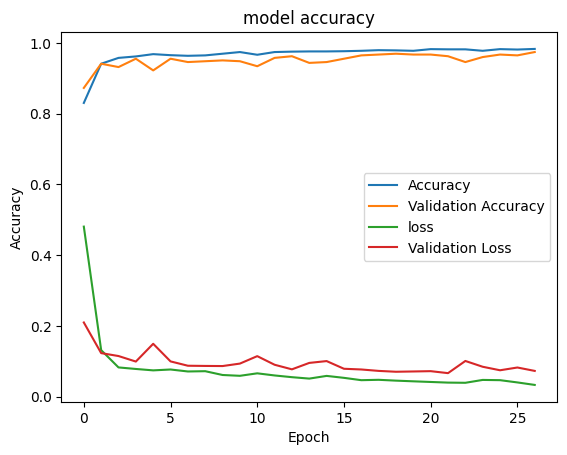

In [8]:
# Extract the training and validation loss from the history object
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plot the training and validation loss
epochs = range(1, len(training_loss) + 1)
plt.plot(epochs, training_loss, label='Entraînement')
plt.plot(epochs, validation_loss, label='Validation')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.title('Courbe de suivi de l\'entraînement')
plt.legend()
plt.show()
# Plot the training and validation loss
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [9]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import numpy as np

# Assuming y_true and y_pred are your actual and predicted labels
# Example data, replace these with your actual data
y_true = [0, 1, 2, 3, 4, 5, 0, 1, 2, 3]
y_pred = [0, 1, 2, 3, 4, 0, 1, 2, 3, 5]

# Create a confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"\nAccuracy: {accuracy:.2f}")

# Print classification report
target_names = ['Engaged', 'Confused', 'Frustrated', 'Bored', 'Drowsy', 'Looking away']
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=target_names))


Confusion Matrix:
[[1 1 0 0 0 0]
 [0 1 1 0 0 0]
 [0 0 1 1 0 0]
 [0 0 0 1 0 1]
 [0 0 0 0 1 0]
 [1 0 0 0 0 0]]

Accuracy: 0.50

Classification Report:
              precision    recall  f1-score   support

     Engaged       0.50      0.50      0.50         2
    Confused       0.50      0.50      0.50         2
  Frustrated       0.50      0.50      0.50         2
       Bored       0.50      0.50      0.50         2
      Drowsy       1.00      1.00      1.00         1
Looking away       0.00      0.00      0.00         1

    accuracy                           0.50        10
   macro avg       0.50      0.50      0.50        10
weighted avg       0.50      0.50      0.50        10



In [10]:
#Train CNN using data-augmentation
# Create an instance of the ImageDataGenerator for data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create a generator for training data with data augmentation
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    #class_mode='binary',  # Assuming binary classification
    shuffle=True  # Set to True for training data
)


val_generator =  val_datagen.flow_from_directory(
    data_dir,
    subset="validation",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False  # Set to False for validation data
)

# Compile your model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train your model using the augmented dataset
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=[tensorboard_callback, early_stopping]
)



Found 2120 images belonging to 6 classes.
Found 0 images belonging to 6 classes.
Epoch 1/100
67/67 [==============================] - ETA: 0s - loss: 0.4568 - accuracy: 0.1759

67/67 [==============================] - 29s 399ms/step - loss: 0.4568 - accuracy: 0.1759
Epoch 2/100
67/67 [==============================] - ETA: 0s - loss: 0.4495 - accuracy: 0.1991

67/67 [==============================] - 27s 410ms/step - loss: 0.4495 - accuracy: 0.1991
Epoch 3/100
67/67 [==============================] - ETA: 0s - loss: 0.4429 - accuracy: 0.2344

67/67 [==============================] - 27s 406ms/step - loss: 0.4429 - accuracy: 0.2344
Epoch 4/100
67/67 [==============================] - ETA: 0s - loss: 0.3737 - accuracy: 0.3811

67/67 [==============================] - 27s 409ms/step - loss: 0.3737 - accuracy: 0.3811
Epoch 5/100
67/67 [==============================] - ETA: 0s - loss: 0.3237 - accuracy: 0.4519

67/67 [==============================] - 29s 440ms/step - loss: 0.3237 - accuracy: 0.4519
Epoch 6/100
67/67 [==============================] - ETA: 0s - loss: 0.2976 - accuracy: 0.5014

67/67 [==============================] - 28s 413ms/step - loss: 0.2976 - accuracy: 0.5014
Epoch 7/100
67/67 [==============================] - ETA: 0s - loss: 0.2930 - accuracy: 0.5325

67/67 [==============================] - 28s 419ms/step - loss: 0.2930 - accuracy: 0.5325
Epoch 8/100
67/67 [==============================] - ETA: 0s - loss: 0.2876 - accuracy: 0.5382

67/67 [==============================] - 27s 405ms/step - loss: 0.2876 - accuracy: 0.5382
Epoch 9/100
67/67 [==============================] - ETA: 0s - loss: 0.2738 - accuracy: 0.5623

67/67 [==============================] - 27s 399ms/step - loss: 0.2738 - accuracy: 0.5623
Epoch 10/100
67/67 [==============================] - ETA: 0s - loss: 0.2753 - accuracy: 0.5590

67/67 [==============================] - 27s 404ms/step - loss: 0.2753 - accuracy: 0.5590
Epoch 11/100
67/67 [==============================] - ETA: 0s - loss: 0.2506 - accuracy: 0.6212

67/67 [==============================] - 27s 404ms/step - loss: 0.2506 - accuracy: 0.6212
Epoch 12/100
67/67 [==============================] - ETA: 0s - loss: 0.2436 - accuracy: 0.6137

67/67 [==============================] - 27s 396ms/step - loss: 0.2436 - accuracy: 0.6137
Epoch 13/100
67/67 [==============================] - ETA: 0s - loss: 0.2305 - accuracy: 0.6467

67/67 [==============================] - 27s 403ms/step - loss: 0.2305 - accuracy: 0.6467
Epoch 14/100
67/67 [==============================] - ETA: 0s - loss: 0.2305 - accuracy: 0.6467

67/67 [==============================] - 27s 402ms/step - loss: 0.2305 - accuracy: 0.6467
Epoch 15/100
67/67 [==============================] - ETA: 0s - loss: 0.2204 - accuracy: 0.6552

67/67 [==============================] - 27s 404ms/step - loss: 0.2204 - accuracy: 0.6552
Epoch 16/100
67/67 [==============================] - ETA: 0s - loss: 0.2156 - accuracy: 0.6698

67/67 [==============================] - 27s 409ms/step - loss: 0.2156 - accuracy: 0.6698
Epoch 17/100
67/67 [==============================] - ETA: 0s - loss: 0.2083 - accuracy: 0.6807

67/67 [==============================] - 27s 392ms/step - loss: 0.2083 - accuracy: 0.6807
Epoch 18/100
67/67 [==============================] - ETA: 0s - loss: 0.2025 - accuracy: 0.6825

67/67 [==============================] - 27s 401ms/step - loss: 0.2025 - accuracy: 0.6825
Epoch 19/100
67/67 [==============================] - ETA: 0s - loss: 0.1956 - accuracy: 0.7127

67/67 [==============================] - 27s 406ms/step - loss: 0.1956 - accuracy: 0.7127
Epoch 20/100
67/67 [==============================] - ETA: 0s - loss: 0.1937 - accuracy: 0.7047

67/67 [==============================] - 27s 402ms/step - loss: 0.1937 - accuracy: 0.7047
Epoch 21/100
67/67 [==============================] - ETA: 0s - loss: 0.2026 - accuracy: 0.6873

67/67 [==============================] - 27s 408ms/step - loss: 0.2026 - accuracy: 0.6873
Epoch 22/100
67/67 [==============================] - ETA: 0s - loss: 0.1948 - accuracy: 0.7146

67/67 [==============================] - 28s 415ms/step - loss: 0.1948 - accuracy: 0.7146
Epoch 23/100
67/67 [==============================] - ETA: 0s - loss: 0.1815 - accuracy: 0.7425

67/67 [==============================] - 28s 420ms/step - loss: 0.1815 - accuracy: 0.7425
Epoch 24/100
67/67 [==============================] - ETA: 0s - loss: 0.1825 - accuracy: 0.7269

67/67 [==============================] - 27s 405ms/step - loss: 0.1825 - accuracy: 0.7269
Epoch 25/100
67/67 [==============================] - ETA: 0s - loss: 0.1804 - accuracy: 0.7495

67/67 [==============================] - 28s 412ms/step - loss: 0.1804 - accuracy: 0.7495
Epoch 26/100
67/67 [==============================] - ETA: 0s - loss: 0.1790 - accuracy: 0.7420

67/67 [==============================] - 27s 408ms/step - loss: 0.1790 - accuracy: 0.7420
Epoch 27/100
67/67 [==============================] - ETA: 0s - loss: 0.1769 - accuracy: 0.7514

67/67 [==============================] - 27s 401ms/step - loss: 0.1769 - accuracy: 0.7514
Epoch 28/100
67/67 [==============================] - ETA: 0s - loss: 0.1714 - accuracy: 0.7660

67/67 [==============================] - 27s 405ms/step - loss: 0.1714 - accuracy: 0.7660
Epoch 29/100
67/67 [==============================] - ETA: 0s - loss: 0.1704 - accuracy: 0.7613

67/67 [==============================] - 29s 434ms/step - loss: 0.1704 - accuracy: 0.7613
Epoch 30/100
67/67 [==============================] - ETA: 0s - loss: 0.1722 - accuracy: 0.7684

67/67 [==============================] - 27s 410ms/step - loss: 0.1722 - accuracy: 0.7684
Epoch 31/100
67/67 [==============================] - ETA: 0s - loss: 0.1712 - accuracy: 0.7627

67/67 [==============================] - 27s 404ms/step - loss: 0.1712 - accuracy: 0.7627
Epoch 32/100
67/67 [==============================] - ETA: 0s - loss: 0.1678 - accuracy: 0.7807

67/67 [==============================] - 27s 404ms/step - loss: 0.1678 - accuracy: 0.7807
Epoch 33/100
67/67 [==============================] - ETA: 0s - loss: 0.1594 - accuracy: 0.7873

67/67 [==============================] - 27s 405ms/step - loss: 0.1594 - accuracy: 0.7873
Epoch 34/100
67/67 [==============================] - ETA: 0s - loss: 0.1554 - accuracy: 0.8061

67/67 [==============================] - 27s 402ms/step - loss: 0.1554 - accuracy: 0.8061
Epoch 35/100
67/67 [==============================] - ETA: 0s - loss: 0.1640 - accuracy: 0.7736

67/67 [==============================] - 27s 404ms/step - loss: 0.1640 - accuracy: 0.7736
Epoch 36/100
67/67 [==============================] - ETA: 0s - loss: 0.1538 - accuracy: 0.8028

67/67 [==============================] - 27s 396ms/step - loss: 0.1538 - accuracy: 0.8028
Epoch 37/100
67/67 [==============================] - ETA: 0s - loss: 0.1577 - accuracy: 0.7844

67/67 [==============================] - 27s 406ms/step - loss: 0.1577 - accuracy: 0.7844
Epoch 38/100
67/67 [==============================] - ETA: 0s - loss: 0.1615 - accuracy: 0.7858

67/67 [==============================] - 27s 401ms/step - loss: 0.1615 - accuracy: 0.7858
Epoch 39/100
67/67 [==============================] - ETA: 0s - loss: 0.1520 - accuracy: 0.8094

67/67 [==============================] - 27s 403ms/step - loss: 0.1520 - accuracy: 0.8094
Epoch 40/100
67/67 [==============================] - ETA: 0s - loss: 0.1520 - accuracy: 0.8075

67/67 [==============================] - 27s 401ms/step - loss: 0.1520 - accuracy: 0.8075
Epoch 41/100
67/67 [==============================] - ETA: 0s - loss: 0.1447 - accuracy: 0.8142

67/67 [==============================] - 27s 406ms/step - loss: 0.1447 - accuracy: 0.8142
Epoch 42/100
67/67 [==============================] - ETA: 0s - loss: 0.1436 - accuracy: 0.8137

67/67 [==============================] - 27s 409ms/step - loss: 0.1436 - accuracy: 0.8137
Epoch 43/100
67/67 [==============================] - ETA: 0s - loss: 0.1538 - accuracy: 0.7981

67/67 [==============================] - 27s 406ms/step - loss: 0.1538 - accuracy: 0.7981
Epoch 44/100
67/67 [==============================] - ETA: 0s - loss: 0.1454 - accuracy: 0.7995

67/67 [==============================] - 27s 405ms/step - loss: 0.1454 - accuracy: 0.7995
Epoch 45/100
67/67 [==============================] - ETA: 0s - loss: 0.1436 - accuracy: 0.8132

67/67 [==============================] - 27s 408ms/step - loss: 0.1436 - accuracy: 0.8132
Epoch 46/100
67/67 [==============================] - ETA: 0s - loss: 0.1362 - accuracy: 0.8349

67/67 [==============================] - 27s 408ms/step - loss: 0.1362 - accuracy: 0.8349
Epoch 47/100
67/67 [==============================] - ETA: 0s - loss: 0.1383 - accuracy: 0.8203

67/67 [==============================] - 27s 401ms/step - loss: 0.1383 - accuracy: 0.8203
Epoch 48/100
67/67 [==============================] - ETA: 0s - loss: 0.1373 - accuracy: 0.8278

67/67 [==============================] - 27s 404ms/step - loss: 0.1373 - accuracy: 0.8278
Epoch 49/100
67/67 [==============================] - ETA: 0s - loss: 0.1372 - accuracy: 0.8325

67/67 [==============================] - 27s 409ms/step - loss: 0.1372 - accuracy: 0.8325
Epoch 50/100
67/67 [==============================] - ETA: 0s - loss: 0.1360 - accuracy: 0.8269

67/67 [==============================] - 27s 409ms/step - loss: 0.1360 - accuracy: 0.8269
Epoch 51/100
67/67 [==============================] - ETA: 0s - loss: 0.1326 - accuracy: 0.8335

67/67 [==============================] - 29s 438ms/step - loss: 0.1326 - accuracy: 0.8335
Epoch 52/100
67/67 [==============================] - ETA: 0s - loss: 0.1284 - accuracy: 0.8495

67/67 [==============================] - 27s 400ms/step - loss: 0.1284 - accuracy: 0.8495
Epoch 53/100
67/67 [==============================] - ETA: 0s - loss: 0.1327 - accuracy: 0.8401

67/67 [==============================] - 28s 412ms/step - loss: 0.1327 - accuracy: 0.8401
Epoch 54/100
67/67 [==============================] - ETA: 0s - loss: 0.1257 - accuracy: 0.8481

67/67 [==============================] - 27s 408ms/step - loss: 0.1257 - accuracy: 0.8481
Epoch 55/100
67/67 [==============================] - ETA: 0s - loss: 0.1266 - accuracy: 0.8453

67/67 [==============================] - 27s 411ms/step - loss: 0.1266 - accuracy: 0.8453
Epoch 56/100
67/67 [==============================] - ETA: 0s - loss: 0.1247 - accuracy: 0.8448

67/67 [==============================] - 27s 406ms/step - loss: 0.1247 - accuracy: 0.8448
Epoch 57/100
67/67 [==============================] - ETA: 0s - loss: 0.1241 - accuracy: 0.8542

67/67 [==============================] - 27s 407ms/step - loss: 0.1241 - accuracy: 0.8542
Epoch 58/100
67/67 [==============================] - ETA: 0s - loss: 0.1284 - accuracy: 0.8330

67/67 [==============================] - 27s 409ms/step - loss: 0.1284 - accuracy: 0.8330
Epoch 59/100
67/67 [==============================] - ETA: 0s - loss: 0.1175 - accuracy: 0.8618

67/67 [==============================] - 27s 405ms/step - loss: 0.1175 - accuracy: 0.8618
Epoch 60/100
67/67 [==============================] - ETA: 0s - loss: 0.1200 - accuracy: 0.8613

67/67 [==============================] - 27s 404ms/step - loss: 0.1200 - accuracy: 0.8613
Epoch 61/100
67/67 [==============================] - ETA: 0s - loss: 0.1238 - accuracy: 0.8509

67/67 [==============================] - 27s 411ms/step - loss: 0.1238 - accuracy: 0.8509
Epoch 62/100
67/67 [==============================] - ETA: 0s - loss: 0.1224 - accuracy: 0.8528

67/67 [==============================] - 27s 401ms/step - loss: 0.1224 - accuracy: 0.8528
Epoch 63/100
67/67 [==============================] - ETA: 0s - loss: 0.1129 - accuracy: 0.8675

67/67 [==============================] - 27s 405ms/step - loss: 0.1129 - accuracy: 0.8675
Epoch 64/100
67/67 [==============================] - ETA: 0s - loss: 0.1119 - accuracy: 0.8637

67/67 [==============================] - 27s 408ms/step - loss: 0.1119 - accuracy: 0.8637
Epoch 65/100
67/67 [==============================] - ETA: 0s - loss: 0.1124 - accuracy: 0.8656

67/67 [==============================] - 27s 404ms/step - loss: 0.1124 - accuracy: 0.8656
Epoch 66/100
67/67 [==============================] - ETA: 0s - loss: 0.1145 - accuracy: 0.8618

67/67 [==============================] - 27s 405ms/step - loss: 0.1145 - accuracy: 0.8618
Epoch 67/100
67/67 [==============================] - ETA: 0s - loss: 0.1039 - accuracy: 0.8797

67/67 [==============================] - 27s 407ms/step - loss: 0.1039 - accuracy: 0.8797
Epoch 68/100
67/67 [==============================] - ETA: 0s - loss: 0.1031 - accuracy: 0.8797

67/67 [==============================] - 28s 407ms/step - loss: 0.1031 - accuracy: 0.8797
Epoch 69/100
67/67 [==============================] - ETA: 0s - loss: 0.1091 - accuracy: 0.8684

67/67 [==============================] - 27s 406ms/step - loss: 0.1091 - accuracy: 0.8684
Epoch 70/100
67/67 [==============================] - ETA: 0s - loss: 0.1121 - accuracy: 0.8594

67/67 [==============================] - 27s 402ms/step - loss: 0.1121 - accuracy: 0.8594
Epoch 71/100
67/67 [==============================] - ETA: 0s - loss: 0.1075 - accuracy: 0.8632

67/67 [==============================] - 29s 438ms/step - loss: 0.1075 - accuracy: 0.8632
Epoch 72/100
67/67 [==============================] - ETA: 0s - loss: 0.1028 - accuracy: 0.8825

67/67 [==============================] - 28s 410ms/step - loss: 0.1028 - accuracy: 0.8825
Epoch 73/100
67/67 [==============================] - ETA: 0s - loss: 0.0994 - accuracy: 0.8797

67/67 [==============================] - 27s 407ms/step - loss: 0.0994 - accuracy: 0.8797
Epoch 74/100
67/67 [==============================] - ETA: 0s - loss: 0.1122 - accuracy: 0.8703

67/67 [==============================] - 28s 415ms/step - loss: 0.1122 - accuracy: 0.8703
Epoch 75/100
67/67 [==============================] - ETA: 0s - loss: 0.1119 - accuracy: 0.8623

67/67 [==============================] - 27s 404ms/step - loss: 0.1119 - accuracy: 0.8623
Epoch 76/100
67/67 [==============================] - ETA: 0s - loss: 0.1053 - accuracy: 0.8759

67/67 [==============================] - 27s 399ms/step - loss: 0.1053 - accuracy: 0.8759
Epoch 77/100
67/67 [==============================] - ETA: 0s - loss: 0.0956 - accuracy: 0.8920

67/67 [==============================] - 27s 405ms/step - loss: 0.0956 - accuracy: 0.8920
Epoch 78/100
67/67 [==============================] - ETA: 0s - loss: 0.1066 - accuracy: 0.8745

67/67 [==============================] - 27s 404ms/step - loss: 0.1066 - accuracy: 0.8745
Epoch 79/100
67/67 [==============================] - ETA: 0s - loss: 0.1135 - accuracy: 0.8637

67/67 [==============================] - 27s 397ms/step - loss: 0.1135 - accuracy: 0.8637
Epoch 80/100
67/67 [==============================] - ETA: 0s - loss: 0.0954 - accuracy: 0.8858

67/67 [==============================] - 27s 406ms/step - loss: 0.0954 - accuracy: 0.8858
Epoch 81/100
67/67 [==============================] - ETA: 0s - loss: 0.0946 - accuracy: 0.8934

67/67 [==============================] - 27s 410ms/step - loss: 0.0946 - accuracy: 0.8934
Epoch 82/100
67/67 [==============================] - ETA: 0s - loss: 0.0934 - accuracy: 0.8976

67/67 [==============================] - 27s 401ms/step - loss: 0.0934 - accuracy: 0.8976
Epoch 83/100
67/67 [==============================] - ETA: 0s - loss: 0.1015 - accuracy: 0.8759

67/67 [==============================] - 27s 402ms/step - loss: 0.1015 - accuracy: 0.8759
Epoch 84/100
67/67 [==============================] - ETA: 0s - loss: 0.0979 - accuracy: 0.8877

67/67 [==============================] - 27s 406ms/step - loss: 0.0979 - accuracy: 0.8877
Epoch 85/100
67/67 [==============================] - ETA: 0s - loss: 0.0964 - accuracy: 0.8892

67/67 [==============================] - 27s 408ms/step - loss: 0.0964 - accuracy: 0.8892
Epoch 86/100
67/67 [==============================] - ETA: 0s - loss: 0.0941 - accuracy: 0.8934

67/67 [==============================] - 27s 400ms/step - loss: 0.0941 - accuracy: 0.8934
Epoch 87/100
67/67 [==============================] - ETA: 0s - loss: 0.0952 - accuracy: 0.8882

67/67 [==============================] - 27s 407ms/step - loss: 0.0952 - accuracy: 0.8882
Epoch 88/100
67/67 [==============================] - ETA: 0s - loss: 0.1016 - accuracy: 0.8802

67/67 [==============================] - 27s 401ms/step - loss: 0.1016 - accuracy: 0.8802
Epoch 89/100
67/67 [==============================] - ETA: 0s - loss: 0.0903 - accuracy: 0.8915

67/67 [==============================] - 27s 403ms/step - loss: 0.0903 - accuracy: 0.8915
Epoch 90/100
67/67 [==============================] - ETA: 0s - loss: 0.0871 - accuracy: 0.9019

67/67 [==============================] - 29s 436ms/step - loss: 0.0871 - accuracy: 0.9019
Epoch 91/100
67/67 [==============================] - ETA: 0s - loss: 0.0890 - accuracy: 0.8981

67/67 [==============================] - 27s 400ms/step - loss: 0.0890 - accuracy: 0.8981
Epoch 92/100
67/67 [==============================] - ETA: 0s - loss: 0.0881 - accuracy: 0.8991

67/67 [==============================] - 27s 398ms/step - loss: 0.0881 - accuracy: 0.8991
Epoch 93/100
67/67 [==============================] - ETA: 0s - loss: 0.0849 - accuracy: 0.9099

67/67 [==============================] - 27s 399ms/step - loss: 0.0849 - accuracy: 0.9099
Epoch 94/100
67/67 [==============================] - ETA: 0s - loss: 0.0932 - accuracy: 0.8934

67/67 [==============================] - 27s 400ms/step - loss: 0.0932 - accuracy: 0.8934
Epoch 95/100
67/67 [==============================] - ETA: 0s - loss: 0.0882 - accuracy: 0.8948

67/67 [==============================] - 27s 397ms/step - loss: 0.0882 - accuracy: 0.8948
Epoch 96/100
67/67 [==============================] - ETA: 0s - loss: 0.0876 - accuracy: 0.9014

67/67 [==============================] - 27s 402ms/step - loss: 0.0876 - accuracy: 0.9014
Epoch 97/100
67/67 [==============================] - ETA: 0s - loss: 0.0899 - accuracy: 0.9019

67/67 [==============================] - 27s 392ms/step - loss: 0.0899 - accuracy: 0.9019
Epoch 98/100
67/67 [==============================] - ETA: 0s - loss: 0.0821 - accuracy: 0.9090

67/67 [==============================] - 26s 385ms/step - loss: 0.0821 - accuracy: 0.9090
Epoch 99/100
67/67 [==============================] - ETA: 0s - loss: 0.0899 - accuracy: 0.8972

67/67 [==============================] - 27s 402ms/step - loss: 0.0899 - accuracy: 0.8972
Epoch 100/100
67/67 [==============================] - ETA: 0s - loss: 0.0989 - accuracy: 0.8755

67/67 [==============================] - 27s 398ms/step - loss: 0.0989 - accuracy: 0.8755


**After data augmantation**

<ipython-input-11-7f71695e6234>:17: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  count = sum(1 for label in class_distribution if label == class_label)


Number of augmented samples: 67
Class 0: 423 samples
Class 1: 358 samples
Class 2: 369 samples
Class 3: 263 samples
Class 4: 347 samples
Class 5: 360 samples
Number of original samples: 2120
Batch size during training: 32
Number of augmented samples per epoch: 67840
Number of epochs: 100
Total number of augmented samples: 6784000


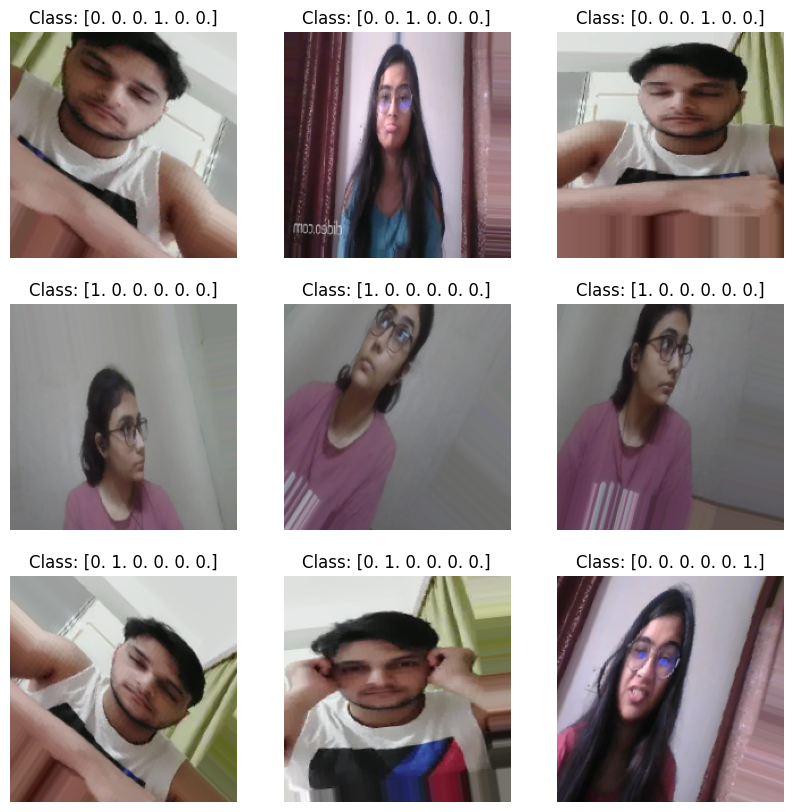

In [11]:
#The number of samples in your dataset after applying data augmentation.
num_original_samples = len(train_generator.filenames)  # Number of original samples in your dataset
batch_size = train_generator.batch_size  # Batch size used during training
num_augmented_samples_per_epoch = num_original_samples * batch_size
num_epochs = 100  # Replace with the actual number of epochs
total_augmented_samples = num_epochs * num_augmented_samples_per_epoch

# Number of Samples:
num_samples = len(train_generator)
print("Number of augmented samples:", num_samples)

#Class Distribution:
class_distribution = train_generator.classes
unique_classes = set(class_distribution)

for class_label in unique_classes:
    count = sum(1 for label in class_distribution if label == class_label)
    print(f"Class {class_label}: {count} samples")

# Print the results
print("Number of original samples:", num_original_samples)
print("Batch size during training:", batch_size)
print("Number of augmented samples per epoch:", num_augmented_samples_per_epoch)
print("Number of epochs:", num_epochs)
print("Total number of augmented samples:", total_augmented_samples)


#Visual Inspection:
import matplotlib.pyplot as plt

# Display a few augmented images
images, labels = train_generator.next()

plt.figure(figsize=(10, 10))
for i in range(min(9, batch_size)):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f"Class: {labels[i]}")
    plt.axis("off")

plt.show()


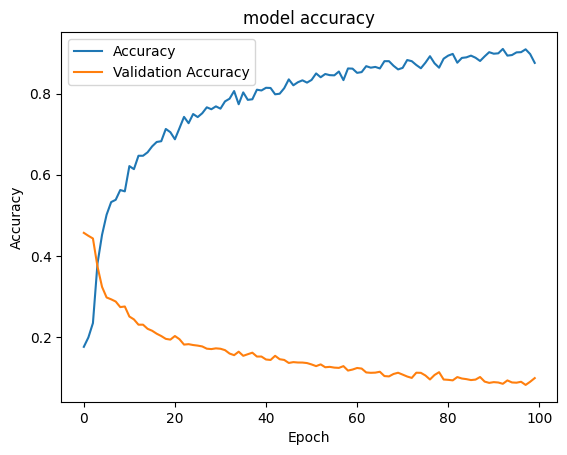

In [15]:

# Plot the training and validation loss
plt.plot(history.history["accuracy"])
#plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [ ]:
# Cette ligne importe la bibliothèque "files" de Google Colab, qui permet de charger des fichiers depuis votre ordinateur vers l'environnement Colab.
from google.colab import files
# Cette ligne demande à l'utilisateur de télécharger un fichier (une image dans ce cas) vers l'environnement Colab. Le fichier téléchargé sera stocké dans la variable file_to_predict.
file_to_predict = files.upload()
# Cette ligne itère sur les fichiers téléchargés (dans le cas où plusieurs fichiers auraient été téléchargés) et effectue les étapes suivantes pour chaque fichier.
for file_ in file_to_predict:
  #Cette ligne utilise la fonction cv2.imread de la bibliothèque OpenCV pour lire l'image téléchargée à partir du fichier.
  #L'image est stockée dans la variable image_to_predict.
    image_to_predict = cv2.imread(file_,cv2.IMREAD_COLOR)
    #Cette ligne affiche l'image en utilisant plt.imshow de la bibliothèque matplotlib.
    #cv2.cvtColor est utilisé pour convertir l'image du format BGR (utilisé par OpenCV) en format RGB (utilisé par matplotlib).
    plt.imshow(cv2.cvtColor(image_to_predict, cv2.COLOR_BGR2RGB))
    plt.show()
    #Cette ligne redimensionne l'image à une taille de 200x200 pixels à l'aide de cv2.resize et l'expands en ajoutant une dimension supplémentaire à l'aide de np.expand_dims.
    #Cela est nécessaire pour que l'image corresponde à la forme attendue par le modèle (une seule image avec les dimensions spécifiées).
    img_to_predict = np.expand_dims(cv2.resize(image_to_predict,(200,200)), axis=0)
    #Cette ligne effectue la prédiction en utilisant le modèle CNN entraîné (model.predict). La variable res contient les résultats de la prédiction.
    res = model.predict(img_to_predict)
predicted_class = np.argmax(res)  # Obtient l'indice de la classe prédite avec la plus haute probabilité
if predicted_class == 0:
    plt.imshow(cv2.cvtColor(image_engagement, cv2.COLOR_BGR2RGB))
    plt.show()
    print("Learner Engaged!")
elif predicted_class == 1:
    plt.imshow(cv2.cvtColor(image_notEngaged, cv2.COLOR_BGR2RGB))
    plt.show()
    print("Learner Not engaged!")
#Ce code permet de charger une image, de faire des prédictions avec le modèle CNN et d'afficher une image correspondant